In [1]:
import shutup
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tsgcn.simulation import MsprimeSimulation
from tsgcn.util import get_idle_gpu
from tsgcn.data import TreeSequenceData, TreeSequencesDataset
from tsgcn.model import BiGCNModel, BiGCNEncoder

import tskit

shutup.please()

/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is depr

In [2]:
# this device variable will get used later during training
device = torch.device(f"cuda:{get_idle_gpu()}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
## CONSTANTS
seed = 11379
num_reps = 400
sp_name = "HomSap"
chrom = None
length = 50_000_000
model_name ="OutOfAfrica_3G09"
sample_size=10
num_windows = 100
HomSap_chr13_OOA = MsprimeSimulation(seed, num_reps, sp_name, model_name, "data/raw/", chrom, length, sample_size, n_threads=200)
breaks = np.linspace(0, HomSap_chr13_OOA.contig.length, num_windows+1)

In [4]:
# Just exploring the output of convert_tseq
from tsgcn.util import convert_tseq
ts=tskit.load(HomSap_chr13_OOA.ts_paths[0])
eix, ei, nf, sq = convert_tseq(ts)
a=TreeSequenceData(edge_index=eix, edge_interval=ei, x = nf, sequence_length=sq)

In [5]:
# Importing our dataset
dataset = TreeSequencesDataset("data/", HomSap_chr13_OOA.sims_path,seeds=HomSap_chr13_OOA.seed_array)
dataset.process_y(num_windows=num_windows)

Processing...
Done!


In [6]:
dataset[0]

TreeSequenceData(x=[61391, 1], edge_index=[2, 372677], edge_interval=[2, 372677], sequence_length=50000000.0, y=[100])

In [7]:
t = BiGCNEncoder(1,4)
a = t(dataset[0])

In [8]:
dataset.len()

400

In [11]:
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dataset,[240, 80,80])

trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
validloader = DataLoader(valid_set, batch_size=1, shuffle=True)
testloader = DataLoader(test_set, batch_size=1, shuffle=True)

In [12]:
def get_y(batch):
    #return batch.x[:,0].unsqueeze(1)
    return batch.y.unsqueeze(1)

In [13]:
torch.manual_seed(1793335)
model = BiGCNModel(device, num_encoder_in_features=dataset.num_features, breaks=breaks, pooling="windowed_sum")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs=40
criterion = torch.nn.MSELoss()

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    num_batches = 0
    for batch in trainloader:
        num_batches+=1
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        #print(output.shape, batch.x[:,0].unsqueeze(1).shape)
        loss = criterion(output,get_y(batch))
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    
    train_avg_loss = epoch_loss / num_batches
    val_loss = 0
    model.eval()
    num_batches = 0
    for batch in validloader:
        num_batches+=1
        batch.to(device)
        output = model(batch)
        loss = criterion(output,get_y(batch))
        val_loss += loss.item()
    val_avg_loss = val_loss/num_batches
    
    
    print(f"Epochs: {epoch} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 336139.72 | validation avg. loss: 20128.62
Epochs: 1 | epoch avg. loss: 18875.02 | validation avg. loss: 19060.00
Epochs: 2 | epoch avg. loss: 18008.14 | validation avg. loss: 18124.04
Epochs: 3 | epoch avg. loss: 17095.81 | validation avg. loss: 17202.34
Epochs: 4 | epoch avg. loss: 16007.92 | validation avg. loss: 16042.52
Epochs: 5 | epoch avg. loss: 14780.80 | validation avg. loss: 14843.77
Epochs: 6 | epoch avg. loss: 20373.32 | validation avg. loss: 14155.18
Epochs: 7 | epoch avg. loss: 12795.82 | validation avg. loss: 12430.53
Epochs: 8 | epoch avg. loss: 11174.74 | validation avg. loss: 10668.06
Epochs: 9 | epoch avg. loss: 9636.22 | validation avg. loss: 9335.23
Epochs: 10 | epoch avg. loss: 8127.38 | validation avg. loss: 7699.53
Epochs: 11 | epoch avg. loss: 6709.28 | validation avg. loss: 6502.33
Epochs: 12 | epoch avg. loss: 5413.93 | validation avg. loss: 5259.51
Epochs: 13 | epoch avg. loss: 9479.34 | validation avg. loss: 3821.97
Epochs: 14 

In [14]:
model.eval()
predictions = []
real = []

for batch in testloader:
    
    output = model(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(get_y(batch).detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

In [15]:
model.eval()

BiGCNModel(
  (encoder): BiGCNEncoder(
    (conv_f1): GCNConv(1, 16)
    (conv_f2): GCNConv(16, 8)
    (conv_b1): GCNConv(1, 16)
    (conv_b2): GCNConv(16, 8)
    (batch_norm): BatchNorm1d(16, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (lin): Linear(in_features=16, out_features=8, bias=True)
  )
  (lin1): Linear(in_features=8, out_features=4, bias=True)
  (lin2): Linear(in_features=4, out_features=1, bias=True)
)

In [16]:
predictions.shape

(8000, 1)

In [17]:
real.shape

(8000, 1)

In [18]:
batch = next(iter(testloader))

In [19]:
batch.to(device)
output = model(batch)
criterion(output, get_y(batch))

tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

Visualizing `Predicted~Observed` diversity within a single tree sequence

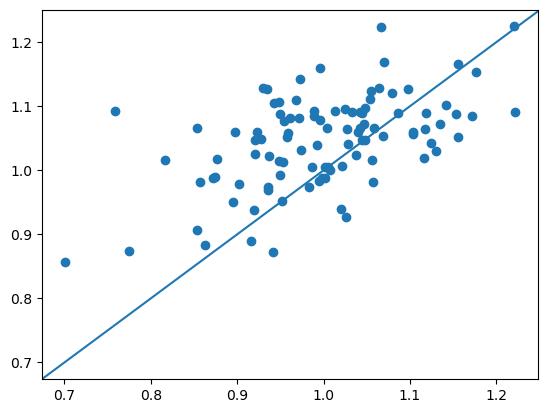

In [20]:
plt.scatter(get_y(batch).detach().cpu().numpy(), output.detach().cpu().numpy())
plt.axline((0.7,0.7), slope=1)

Now across all windows and tree sequences

Text(0.5, 0, 'Observed diversity')

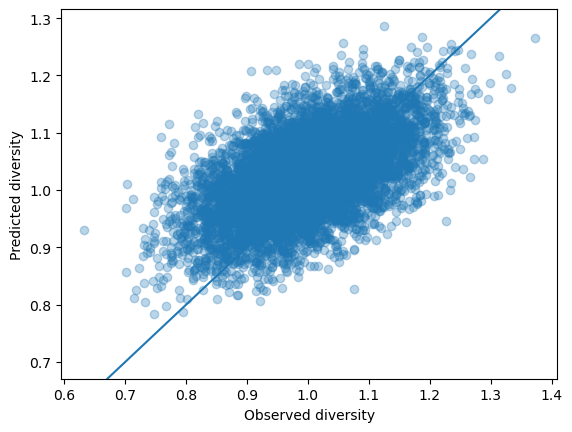

In [21]:


plt.scatter(real, predictions, alpha=0.3)
plt.axline((0.7,0.7), slope=1)

plt.ylabel('Predicted diversity')
plt.xlabel('Observed diversity')

In [ ]:
real.shape

In [ ]:
predictions.shape